<a href="https://colab.research.google.com/github/EddieZ17/colab/blob/main/licenta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tfds-nightly # Fara aceasta instalare nu ni se gaseste setul de date "cars196"
# Uneori este necesar sa dam restart la runtime dupa rularea acestei celule

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 9.2 MB/s 


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd

# Incarcam setul de date si etichetam imaginile

directory = '/drive/MyDrive/data/'

[train_dataset, test_dataset], ds_info = tfds.load(
    'cars196',
    split = ['train', 'test'],
    as_supervised = True,  # Etichetarea 
    with_info = True,
    download = True,
    data_dir = directory,
)

In [4]:
print("Numarul de poze pentru train: %d" % tf.data.experimental.cardinality(train_dataset))
#print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Numarul de poze pentru test: %d" % tf.data.experimental.cardinality(test_dataset))

Numarul de poze pentru train: 8144
Numarul de poze pentru test: 8041


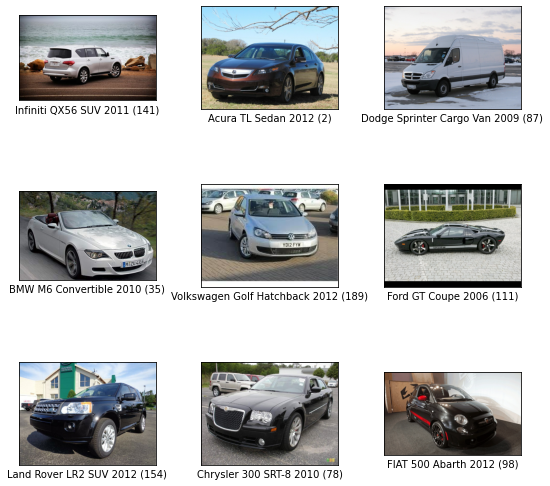

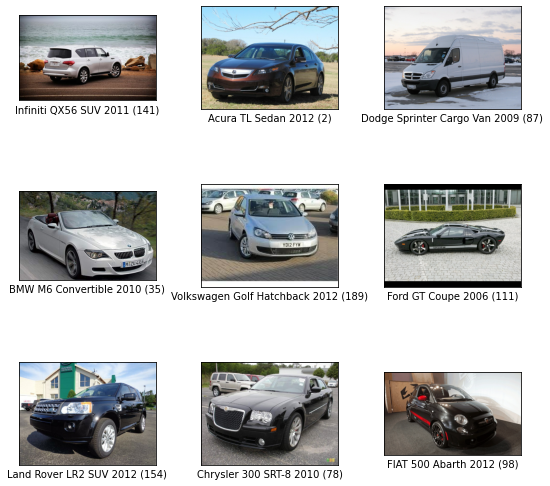

In [5]:
# Vizualizarea unor exemple de imagini din setul de date

tfds.visualization.show_examples(test_dataset, ds_info)

In [6]:
# Prelucrarea imaginilor
# Am incercat sa le redimensionez la (224,224,3) - standardul imagenet insa se 
# memoria RAM a sistemului deoarece dimensiunea este prea mare

train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x,(150, 150)), y))
test_dataset = test_dataset.map(lambda x, y: (tf.image.resize(x,(150, 150)), y))

output_size = ds_info.features['label'].num_classes

train_dataset = train_dataset.cache().batch(50)
test_dataset = test_dataset.cache().batch(50)

In [7]:
# Initializarea modelului MobileNetV2 - ales pentru viteza sa

import tensorflow as tf
import keras

IMG_SHAPE = (150, 150, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape = (150, 150, 3),
                                               include_top = False, 
                                               weights = None, classes = 196)

fine_tune_at = 75

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  
  keras.layers.Dense(2048,activation='relu'),
  keras.layers.Dense(512,activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(196, activation='softmax')
])
print(len(base_model.layers), ' layers')
print(base_model.summary())


adam = tf.keras.optimizers.Adam(lr=0.01)
adagrad = tf.keras.optimizers.Adagrad(learning_rate=0.05)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adagrad, metrics=['acc'])

154  layers
Model: "mobilenetv2_1.00_150"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
# Antrenarea modelului

import time
start = time.time()

history = model.fit(train_dataset, epochs=50, validation_data=test_dataset)

end = time.time()

print('Durata: {} minute'.format((end-start)/60))

Epoch 1/50
 18/163 [==>...........................] - ETA: 24s - loss: 5.2758 - acc: 0.0067

KeyboardInterrupt: ignored